In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from modAL.models import ActiveLearner
import tensorflow as tf
import matplotlib.pyplot as plt

from modAL.uncertainty import margin_sampling
import os
from keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
def create_keras_model():
    model = Sequential()
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [3]:
classifier = KerasClassifier(create_keras_model)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [6]:
initial_idx = np.array([],dtype=np.int32)
for i in range(10):
    idx = np.random.choice(np.where(y_train[:,i]==1)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [7]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [13]:
def uniform(learner, X, n_instances=1):
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(X.shape[0], 2000, replace=False)
    MC_output = K.function([learner.estimator.model.layers[0].input, K.learning_phase()],
                           [learner.estimator.model.layers[-1].output])
    learning_phase = True
    MC_samples = [MC_output([X[random_subset], learning_phase])[0] for _ in range(T)]
    MC_samples = np.array(MC_samples)  # [#samples x batch size x #classes]
    expected_p = np.mean(MC_samples, axis=0)
    acquisition = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

def random_sampling(classifier, X,
                     n_instances: int = 1, random_tie_break: bool = False):
    
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    
    return query_idx, X[query_idx]

In [9]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              epochs=50,
                              batch_size=128,
                              n_queries=100,
                              n_instances=10,
                              verbose=0):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                            verbose=verbose
                           )
    perf_hist = [learner.score(X_test, y_test, verbose=verbose)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx], epochs=epochs, batch_size=batch_size, verbose=verbose)
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test, verbose=0)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
    return perf_hist

In [ ]:
K.clear_session()

In [ ]:
estimator = KerasClassifier(create_keras_model)
uniform_perf_hist = active_learning_procedure(uniform,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

In [ ]:
acc = uniform_perf_hist

queries_range = range(101)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(queries_range, acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')


In [10]:
estimator = KerasClassifier(create_keras_model)
margin_perf_hist = active_learning_procedure(margin_sampling,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Instructions for updating:
Please use `model.predict()` instead.
Accuracy after query 1: 0.6379
Accuracy after query 2: 0.6438
Accuracy after query 3: 0.7094
Accuracy after query 4: 0.6816
Accuracy after query 5: 0.7426
Accuracy after query 6: 0.7506
Accuracy after query 7: 0.7545
Accuracy after query 8: 0.7782
Accuracy after query 9: 0.8108
Accuracy after query 10: 0.8156
Accuracy after query 11: 0.7855
Accuracy after query 12: 0.8533
Accuracy after query 13: 0.8673
Accuracy after query 14: 0.8966
Accuracy after query 15: 0.8819
Accuracy after query 16: 0.8919
Accuracy after query 17: 0.9025
Accuracy after query 18: 0.9007
Accuracy after query 19: 0.9179
Accuracy after query 20: 0.9113
Accuracy after query 21: 0.9163
Accuracy after query 22: 0.9213
Accuracy after query 23: 0.9274
Accuracy after query 24: 0.9282
Accuracy after query 25: 0.9308
Accuracy after query 26: 0.9413
Accuracy after query 27: 0.9399
Accuracy after query 28: 0.9392
Accuracy after query 29: 0.9539
Accuracy after q

In [17]:
margin_perf_hist = active_learning_procedure(margin_sampling,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Accuracy after query 1: 0.6805
Accuracy after query 2: 0.6768
Accuracy after query 3: 0.7331
Accuracy after query 4: 0.7672
Accuracy after query 5: 0.7707
Accuracy after query 6: 0.8025
Accuracy after query 7: 0.7976
Accuracy after query 8: 0.8264
Accuracy after query 9: 0.8418
Accuracy after query 10: 0.8572
Accuracy after query 11: 0.7847
Accuracy after query 12: 0.8815
Accuracy after query 13: 0.8888
Accuracy after query 14: 0.8876
Accuracy after query 15: 0.9045
Accuracy after query 16: 0.9004
Accuracy after query 17: 0.9051
Accuracy after query 18: 0.9104
Accuracy after query 19: 0.9123
Accuracy after query 20: 0.9152
Accuracy after query 21: 0.9127
Accuracy after query 22: 0.9076
Accuracy after query 23: 0.9406
Accuracy after query 24: 0.9359
Accuracy after query 25: 0.9462
Accuracy after query 26: 0.9427
Accuracy after query 27: 0.9516
Accuracy after query 28: 0.9451
Accuracy after query 29: 0.9472
Accuracy after query 30: 0.9515
Accuracy after query 31: 0.9530
Accuracy after qu

Text(0.5, 1.0, 'Validation Accuracy')

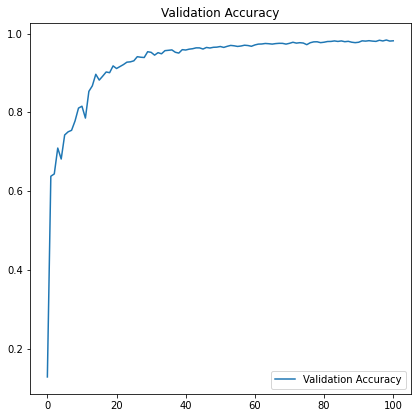

In [11]:
acc = margin_perf_hist

queries_range = range(101)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(queries_range, acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

In [15]:
random_perf_hist = active_learning_procedure(random_sampling,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

Accuracy after query 1: 0.6371
Accuracy after query 2: 0.6174
Accuracy after query 3: 0.7403
Accuracy after query 4: 0.7627
Accuracy after query 5: 0.8012
Accuracy after query 6: 0.7743
Accuracy after query 7: 0.8202
Accuracy after query 8: 0.8117
Accuracy after query 9: 0.8360
Accuracy after query 10: 0.8159
Accuracy after query 11: 0.7997
Accuracy after query 12: 0.8421
Accuracy after query 13: 0.8305
Accuracy after query 14: 0.8527
Accuracy after query 15: 0.8521
Accuracy after query 16: 0.8568
Accuracy after query 17: 0.8742
Accuracy after query 18: 0.8666
Accuracy after query 19: 0.8699
Accuracy after query 20: 0.8787
Accuracy after query 21: 0.8861
Accuracy after query 22: 0.8837
Accuracy after query 23: 0.8956
Accuracy after query 24: 0.8965
Accuracy after query 25: 0.9087
Accuracy after query 26: 0.9107
Accuracy after query 27: 0.9219
Accuracy after query 28: 0.9155
Accuracy after query 29: 0.9254
Accuracy after query 30: 0.9192
Accuracy after query 31: 0.9241
Accuracy after qu

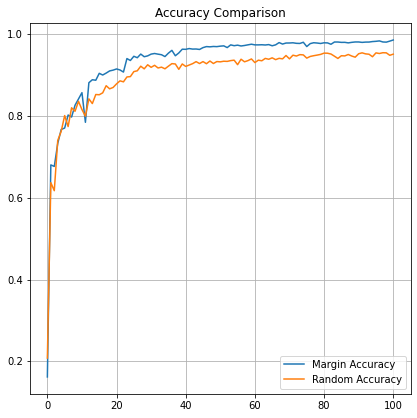

In [19]:
acc_margin = margin_perf_hist
acc_random = random_perf_hist

queries_range = range(101)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(queries_range, acc_margin, label='Margin Accuracy')
plt.plot(queries_range, acc_random, label='Random Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Comparison')
plt.grid()
plt.show()
